In [1]:
import keras 
import tensorflow as tf
import keras.backend.tensorflow_backend as K
from PIL import Image
from imutils import paths
from os import path
from keras.optimizers import Adam,RMSprop
import pandas as pd
keras.__version__
IMAGE_DIMS = (350,250,3)
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array

In [3]:
date_arr = np.load('./new_date_arr.npy',allow_pickle=True)
dust_arr = np.load('./ultra_result_arr_avg_5.npy',allow_pickle=True)
wind_arr = np.load('./wind_arr.npy',allow_pickle=True)
humi_arr = np.load('./humi_arr.npy',allow_pickle=True)

In [4]:
import time

start = time.time() 
imagePaths = sorted(list(paths.list_images('./dataset/image')))
image_arr = []

for i in imagePaths:
    img_name = int(path.splitext(path.basename(i))[0])
    
    if img_name in date_arr :
        image = Image.open(i)
        image = image.resize((IMAGE_DIMS[0],IMAGE_DIMS[1]))
        image = img_to_array(image)
        image_arr.append(image)
        
image_arr = np.array(image_arr, dtype="float") / 255.0        
print("[INFO] data matrix: {} images ({:.2f}MB)".format(len(imagePaths), image_arr.nbytes / (1024 * 1000.0)))

[INFO] data matrix: 18126 images (22940.04MB)


In [5]:
from sklearn.utils import shuffle



con_data_img = image_arr
con_data_val = dust_arr

print(wind_arr.shape)
con_data_wea = np.concatenate([wind_arr.reshape(len(wind_arr),1),humi_arr.reshape(len(humi_arr),1)], axis=1)


# 국내는 PM2.5이 16이상이면 보통
# for i in range(0,dustvalue.shape[0]):
#     if int(dustvalue[i]) > 0 :
#         con_data_img.append(data[i])
#         con_data_val.append(dustvalue[i])
#         con_data_wea.append(add_info[i])
        
# con_data_img, con_data_val, con_data_wea = shuffle(np.array(con_data_img), np.array(con_data_val), np.array(con_data_wea), random_state=0)
# con_data_img = np.array(con_data_img)
# con_data_val = np.array(con_data_val)
# con_data_wea = np.array(con_data_wea)

num = int(con_data_img.shape[0]*0.9)

train_img = con_data_img[:num]
train_val = con_data_val[:num]
train_wea = con_data_wea[:num]

test_img = con_data_img[num:]
test_val = con_data_val[num:]
test_wea = con_data_wea[num:]

print(con_data_img.shape)
print(train_img.shape)
print(test_img.shape)


(11186,)
(11186, 250, 350, 3)
(10067, 250, 350, 3)
(1119, 250, 350, 3)


In [6]:
# import the necessary packages
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, GRU, Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

chanDim=-1
model = Sequential()

# CONV => RELU => POOL
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(IMAGE_DIMS[1], IMAGE_DIMS[0],3)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())


image_input = Input(shape=(IMAGE_DIMS[1], IMAGE_DIMS[0],3))
encoded_image = model(image_input)

# 다음은 문제를 벡터로 인코딩할 숫자 모델을 정의합니다
numeric_input = Input(shape=(2,))
embedded_numeric = Embedding(input_dim=100, output_dim=256, input_length=2)(numeric_input)

# numeric_input2 = Dense(256, activation="linear")(embedded_numeric)
# print(embedded_numeric.shape)

#numeric_input2 = GRU(256)(embedded_numeric)
numeric_input2 = GRU(256)(embedded_numeric)
# print(numeric_input2.shape)


# numeric_input = Input(shape=(8,), dtype='float32')
# numeric_input1 = Dense(1000,activation='linear')(numeric_input)
# numeric_input2 = Dense(100,activation='linear')(numeric_input1)

# 질문 벡터와 이미지 벡터를 연결해 봅시다:
merged = keras.layers.concatenate([encoded_image, numeric_input2],axis=-1)

output = Dense(1)(merged)

# 그리고 상층의 로지스틱 회귀를 수치에 대해 학습시킵니다:
# output = Dense(1024, activation='softmax')(merged)
# output = Dense(128, activation='softmax')(output)
# output = Dense(1)(output)
# 다음은 최종 모델입니다:
model = Model(inputs=[image_input, numeric_input], outputs=output)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
#opt = RMSprop(lr=0.005, rho=0.9, epsilon=None, decay=0.0)
opt = Adam(lr=0.002, epsilon=None, decay=0.0)
model.compile(loss="mse", optimizer=opt,metrics=["accuracy"])
# logcosh, mes, 
H = model.fit([train_img,train_wea], train_val ,batch_size=10, epochs=200)


print("[INFO] serializing network...")
model.save('new-ultra-LSTM-adam-5.model')



Instructions for updating:
Use tf.cast instead.
Epoch 1/200
10067/10067 [==============================] - 44s 4ms/step - loss: 238.4982 - acc: 0.0118
Epoch 2/200
10067/10067 [==============================] - 41s 4ms/step - loss: 180.2647 - acc: 0.0153
Epoch 3/200
10067/10067 [==============================] - 40s 4ms/step - loss: 162.9343 - acc: 0.0160
Epoch 4/200
10067/10067 [==============================] - 40s 4ms/step - loss: 146.8140 - acc: 0.0199
Epoch 5/200
10067/10067 [==============================] - 40s 4ms/step - loss: 135.6074 - acc: 0.0205
Epoch 6/200
10067/10067 [==============================] - 40s 4ms/step - loss: 129.7226 - acc: 0.0241
Epoch 7/200
10067/10067 [==============================] - 41s 4ms/step - loss: 123.7737 - acc: 0.0236
Epoch 8/200
10067/10067 [==============================] - 41s 4ms/step - loss: 120.2062 - acc: 0.0212
Epoch 9/200
10067/10067 [==============================] - 41s 4ms/step - loss: 113.4859 - acc: 0.0229
Epoch 10/200
10067/10067 

10067/10067 [==============================] - 40s 4ms/step - loss: 8.3752 - acc: 0.0501
Epoch 78/200
10067/10067 [==============================] - 41s 4ms/step - loss: 9.7437 - acc: 0.0456
Epoch 79/200
10067/10067 [==============================] - 40s 4ms/step - loss: 8.4237 - acc: 0.0492
Epoch 80/200
10067/10067 [==============================] - 40s 4ms/step - loss: 8.9859 - acc: 0.0503
Epoch 81/200
10067/10067 [==============================] - 40s 4ms/step - loss: 9.1332 - acc: 0.0497
Epoch 82/200
10067/10067 [==============================] - 41s 4ms/step - loss: 14.7142 - acc: 0.0447
Epoch 83/200
10067/10067 [==============================] - 40s 4ms/step - loss: 17.1511 - acc: 0.0426
Epoch 84/200
10067/10067 [==============================] - 40s 4ms/step - loss: 12.6145 - acc: 0.0434
Epoch 85/200
10067/10067 [==============================] - 41s 4ms/step - loss: 11.5154 - acc: 0.0506
Epoch 86/200
10067/10067 [==============================] - 40s 4ms/step - loss: 10.6116 - 

10067/10067 [==============================] - 41s 4ms/step - loss: 4.1981 - acc: 0.0621
Epoch 157/200
10067/10067 [==============================] - 40s 4ms/step - loss: 5.6733 - acc: 0.0607
Epoch 158/200
10067/10067 [==============================] - 41s 4ms/step - loss: 7.8210 - acc: 0.0576
Epoch 159/200
10067/10067 [==============================] - 40s 4ms/step - loss: 3.9187 - acc: 0.0632
Epoch 160/200
10067/10067 [==============================] - 40s 4ms/step - loss: 4.2802 - acc: 0.0666
Epoch 161/200
10067/10067 [==============================] - 40s 4ms/step - loss: 4.8164 - acc: 0.0627
Epoch 162/200
10067/10067 [==============================] - 41s 4ms/step - loss: 5.2879 - acc: 0.0597
Epoch 163/200
10067/10067 [==============================] - 40s 4ms/step - loss: 5.1355 - acc: 0.0631
Epoch 164/200
10067/10067 [==============================] - 40s 4ms/step - loss: 4.0392 - acc: 0.0671
Epoch 165/200
10067/10067 [==============================] - 41s 4ms/step - loss: 5.616

In [8]:
print(image_arr.shape)
print(dust_arr.shape)

print(wind_arr.shape)
print(humi_arr.shape)

print(test_img.shape)
print(test_wea.shape)

print(model.predict([test_img, test_wea]))

y_pred = np.squeeze(np.round(model.predict([test_img, test_wea]).astype(np.int64)))

print(test_val.shape)
print(y_pred.shape)

print(np.round(test_val.astype(np.int64)))
print(y_pred)

(11186, 250, 350, 3)
(11186,)
(11186,)
(11186,)
(1119, 250, 350, 3)
(1119, 2)
[[6.394677 ]
 [3.092186 ]
 [4.9504824]
 ...
 [2.7946806]
 [6.7791853]
 [6.244216 ]]
(1119,)
(1119,)
[2 3 3 ... 3 3 3]
[6 3 4 ... 2 6 6]


In [9]:
RMSE = mean_squared_error(test_val.astype(np.int64), y_pred)**0.5
R2SCORE = r2_score(test_val.astype(np.int64), y_pred)

print("RMSE 는 : " , RMSE)
print("R2SCORE 는 : ", R2SCORE)

RMSE 는 :  11.669411141511537
R2SCORE 는 :  0.031561656427100626


Text(10, 5, 'R-squared = 0.03')

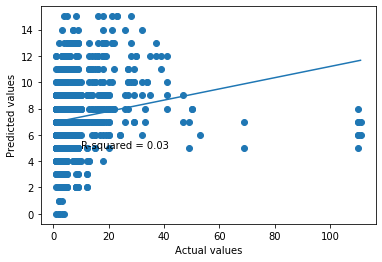

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

test_val=np.squeeze(test_val.astype(np.int64))

plt.scatter(test_val,y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.plot(np.unique(test_val), np.poly1d(np.polyfit(test_val, y_pred, 1))(np.unique(test_val)))

plt.text(70, 50, 'R-squared = %0.2f' % R2SCORE)

In [11]:
np.round(test_val.astype(np.int64))


array([2, 3, 3, ..., 3, 3, 3], dtype=int64)

In [12]:
y_pred

array([6, 3, 4, ..., 2, 6, 6], dtype=int64)